In [ ]:
pip install brokenaxes

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from brokenaxes import BrokenAxes
from scipy.special import hermite, factorial

mpl.rcdefaults()

In [ ]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


#Solution

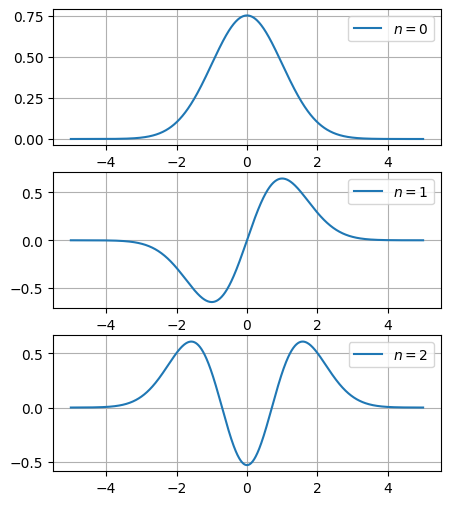

In [ ]:
# params
m, omega, hbar = 1, 1, 1

# wavefunction psi_n(x)
def psi_n(x, n):
    hermite_poly = hermite(n)
    norm_factor = 1/(np.sqrt(2**n*factorial(n))) * (m*omega/(np.pi*hbar))**0.25
    return norm_factor * hermite_poly(np.sqrt(m*omega/hbar)*x) * np.exp(-m*omega*x**2/(2*hbar))

# def energy
def energy(n):
  return (n + 0.5)*hbar*omega

x = np.linspace(-5, 5, 1024)

fig, ax = plt.subplots(3, 1, figsize=(5,6))

for i in range(3):
  ax[i].plot(x, psi_n(x, i), label=f"$n={i}$")
  ax[i].grid()
  ax[i].legend()

plt.show()

# Feed Forward Neural Network

In [ ]:
import torch
from torch import nn

In [ ]:
# hyperparameters
num_features = 1
num_hidden = 64
num_output = 1

# define network
class FFNN(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(FFNN, self).__init__()

        # first layer (input to hidden)
        self.fc1 = nn.Linear(num_features, num_hidden)

        # second layer (hidden to hidden)
        self.fc2 = nn.Linear(num_hidden, num_hidden)

        # third layer (hidden to hidden)
        self.fc3 = nn.Linear(num_hidden, num_hidden)

        # fourth layer (hidden to hidden)
        self.fc4 = nn.Linear(num_hidden, num_hidden)

        # out layer (hidden to output)
        self.fcout = nn.Linear(num_hidden, num_output)

        # define activation function
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.fcout(x)
        return x

net = FFNN(num_features, num_hidden, num_output)

#Loss Function

In [ ]:
class LossFunctions():
  def __init__(self, hbar, m, omega, n, lambda_b, lambda_p, lambda_n):
    self.hbar = hbar
    self.m = m
    self.omega = omega
    self.n = n
    self.lambda_b = lambda_b
    self.lambda_p = lambda_p
    self.lambda_n = lambda_n

  # discrete energies
  def energy(self):
    return (self.n + 0.5)*self.hbar*self.omega

  # boundary loss
  def boundary_loss(self, psi):
    loss = (self.lambda_b/2*(psi[0]**2 + psi[1]**2)).squeeze()
    return loss

  # physics loss
  def physics_loss(self, x, psi, d2psi_dx2):
    d2psi_term = -0.5*self.hbar**2/self.m * d2psi_dx2
    psi_term = psi*( 0.5*self.m*self.omega**2*x**2 - self.energy() )
    loss = self.lambda_p * torch.mean((d2psi_term + psi_term)**2)
    return loss

  # norm loss
  def norm_loss(self, x, psi):
    dx = x[1] - x[0]
    loss = self.lambda_n * (dx * torch.sum(torch.abs(psi)**2) - 1)**2
    return loss

  # analytic
  def analytic(self, x):
    # convert to numpy array if needed
    x = x.detach().numpy() if isinstance(x, torch.Tensor) else np.array(x)
    Hn = hermite(self.n)
    hermite_term = Hn(np.sqrt(self.m*self.omega/self.hbar)*x)
    norm_factor = 1/(np.sqrt(2**self.n*factorial(self.n))) * (self.m*self.omega/(np.pi*self.hbar))**0.25
    psi_n = norm_factor * hermite_term * np.exp(-self.m*self.omega*x**2/(2*self.hbar))

    # convert back to torch tensor
    psi_n = torch.tensor(psi_n, dtype=torch.float32)
    return psi_n


#Train the PINN

In [ ]:
import torch.autograd as autograd
import torch.optim as optim

# setup seeds for reproducibility
seed = 8
torch.manual_seed(seed)

For $n=0$:

In [ ]:
# define boundary points
x_boundary = torch.tensor([-5., 5.]).view(-1, 1).requires_grad_(True)

# define training points
x_physics = torch.linspace(-5, 5, 1000).view(-1, 1).requires_grad_(True)

# define test points (plotting)
x_test = torch.linspace(-5, 5, 1000).view(-1, 1)

# define validation points
x_val = torch.linspace(-5, 5, 1000).view(-1, 1)

# train PINN
hbar, m, omega = 1, 1, 1
lambda_b, lambda_p = 1e-4, 1e-4
num_epochs = 8000

# initialize PINN
PINN = FFNN(num_features=1, num_hidden=64, num_output=1)
optimizer = optim.Adam(PINN.parameters(), lr=1e-4)

# store solutions as training progresses
psi_plot = np.empty((x_test.shape[0], 0))

# setup lists to store training loss and validation error
boundary_loss = []
physics_loss = []
norm_loss = []
total_loss = []
train_error = []
val_error = []

for e in range(num_epochs+1):
  # zero accumulated gradients in parameters
  optimizer.zero_grad()

  # define loss functions
  loss_funcs = LossFunctions(hbar, m, omega, n=0, lambda_b=lambda_b, lambda_p=lambda_p, lambda_n=1e-4)

  # compute boundary loss
  psi = PINN(x_boundary)
  L_boundary = loss_funcs.boundary_loss(psi)
  boundary_loss.append(L_boundary.item())

  # compute physics loss
  psi = PINN(x_physics)
  dpsi_dt = autograd.grad(psi, x_physics, torch.ones_like(psi), create_graph=True)[0]
  d2psi_dt2 = autograd.grad(dpsi_dt, x_physics, torch.ones_like(dpsi_dt), create_graph=True)[0]
  L_physics = loss_funcs.physics_loss(x_physics, psi, d2psi_dt2)
  physics_loss.append(L_physics.item())

  # compute norm loss
  L_norm = loss_funcs.norm_loss(x_physics, psi)
  norm_loss.append(L_norm.item())

  # backpropagate joint loss
  L_total = L_boundary + L_physics + L_norm
  L_total.backward()
  total_loss.append(L_total.item())
  optimizer.step()

  # store training loss and validation error
  if e % 1000 == 0:
    # append training error
    train_error.append(L_total.item())

    # compute and append validation error
    psiv = PINN(x_val)
    # apply normalization so \int |\psi|^2 dx = 1
    #norm_factor = simpson(abs(psiv.detach().numpy().squeeze())**2, x_val.detach().numpy().squeeze())
    #norm_factor = torch.sum(abs(psiv)**2) * (x_val[1] - x_val[0])
    #psiv /= torch.sqrt(norm_factor).float().view(-1, 1)
    val_error.append(torch.mean(torch.abs(psiv - loss_funcs.analytic(x_val))**2))
    print(f"Epoch: {e:4d}, Training Error: {train_error[-1]:.6e}, Validation Loss: {val_error[-1]:.6e}")

  # store solution (plotting)
  psi_e = PINN(x_test).detach().numpy()
  psi_plot = np.hstack((psi_plot, psi_e))

Epoch:    0, Training Error: 1.459462e-04, Validation Loss: 1.377279e-01
Epoch: 1000, Training Error: 5.391457e-08, Validation Loss: 4.548324e-05
Epoch: 2000, Training Error: 3.304837e-08, Validation Loss: 9.598108e-06
Epoch: 3000, Training Error: 2.150025e-08, Validation Loss: 5.361286e-06
Epoch: 4000, Training Error: 1.253035e-08, Validation Loss: 2.895694e-06
Epoch: 5000, Training Error: 7.320094e-09, Validation Loss: 1.654910e-06
Epoch: 6000, Training Error: 4.235352e-09, Validation Loss: 9.398333e-07
Epoch: 7000, Training Error: 2.535460e-09, Validation Loss: 5.333658e-07
Epoch: 8000, Training Error: 1.731338e-09, Validation Loss: 3.273643e-07


Predicted psi(x) values
x = -5.000000, psi = -0.000176
x = -3.888889, psi = 0.000031
x = -2.777778, psi = 0.016552
x = -1.666667, psi = 0.186760
x = -0.555556, psi = 0.643894
x = 0.555556, psi = 0.643891
x = 1.666667, psi = 0.187000
x = 2.777778, psi = 0.016359
x = 3.888889, psi = 0.000128
x = 5.000000, psi = -0.000611


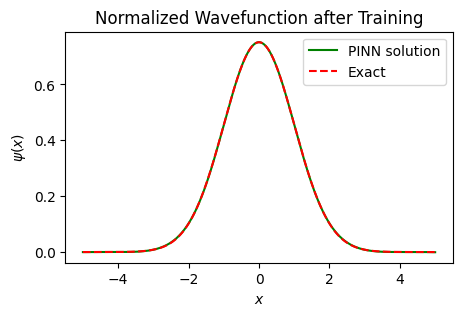

In [ ]:
# predicted solution at the end of training
indices = torch.linspace(0, len(x_test)-1, steps=10).long()
print("Predicted psi(x) values")
for i in range(10):
  print(f"x = {x_test.detach().numpy()[indices[i]].squeeze():.6f}, psi = {psi_plot[indices[i],-1].squeeze():.6f}")

# comparison of final PINN solution with exact solution
psi_pinn = psi_plot[:,-1]
psi_exact = loss_funcs.analytic(x_val.detach().numpy())

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.plot(x_val.detach().numpy(), psi_pinn, color='g', label="PINN solution")
plt.plot(x_val.detach().numpy(), psi_exact, color='r', linestyle='--', label="Exact")
plt.xlabel(r'$x$')
plt.ylabel(r'$\psi(x)$')
plt.title(r'Normalized Wavefunction after Training')
plt.legend()
plt.show()

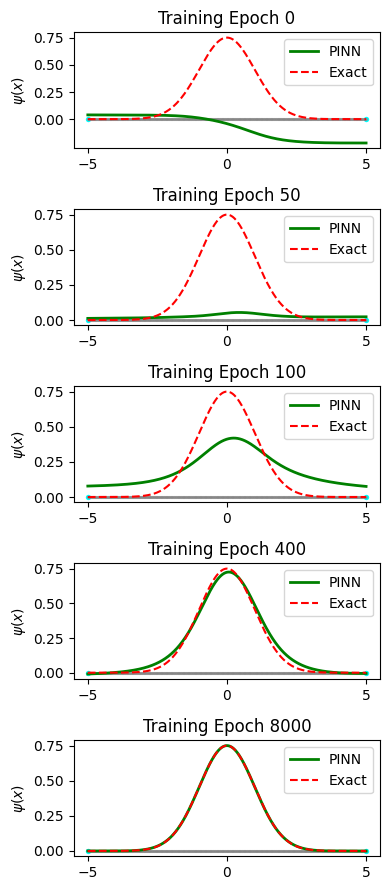

In [ ]:
# plot the PINNs solution over training
epoch_num = [0, 50, 100, 400, 8000]
fig, ax = plt.subplots(len(epoch_num), 1, figsize=(4, 9))

for i in range(len(epoch_num)):
  ax[i].scatter(x_boundary.detach()[:,0], torch.zeros_like(x_boundary)[:,0], s=15, lw=0, color="cyan")
  ax[i].scatter(x_physics.detach()[:,0], torch.zeros_like(x_physics)[:,0], s=5, lw=0, color='grey', alpha=0.2)
  ax[i].plot(x_test[:,0], psi_plot[:,epoch_num[i]], lw=2, label="PINN", color='g')
  ax[i].plot(x_val.detach().numpy(), psi_exact, color='r', linestyle='--', lw=1.5, label="Exact")
  ax[i].set_title(f"Training Epoch {epoch_num[i]}", fontsize=12)
  ax[i].set_xticks([-5,0,5])
  ax[i].set_yticks([0, 0.25, 0.5, 0.75])
  ax[i].legend(fontsize=10)
  ax[i].set_ylabel(r'$\psi(x)$', fontsize=10)

#ax[-1].set_xlabel(r'$x$', fontsize=12)
plt.tight_layout()
plt.savefig("n0_train.pdf")
plt.show()

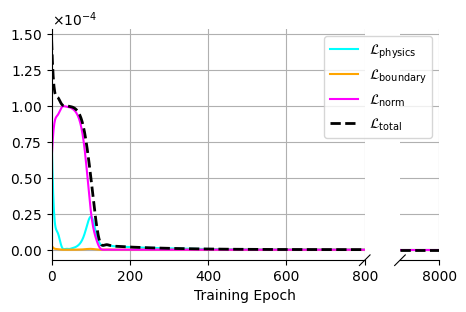

In [ ]:
# plot the loss curve
epoch = np.arange(num_epochs+1)

labels = [r"$\mathcal{L}_\text{physics}$", r"$\mathcal{L}_\text{boundary}$", r"$\mathcal{L}_\text{norm}$", r"$\mathcal{L}_\text{total}$"]
styles = ["-", "-", "-", "--"]
colors = ["cyan", "orange", "magenta", "black"]
linewidths = [1.5, 1.5, 1.5, 2]

fig = plt.figure(figsize=(5, 3))
bax = BrokenAxes(xlims=((0, 800), (7900, 8000)))

for loss_type, label, color, style, linew in zip(
        [physics_loss, boundary_loss, norm_loss, total_loss],
        labels,
        colors,
        styles,
        linewidths):
    bax.plot(epoch, loss_type, linestyle=style, lw=linew, label=label, color=color, alpha=1)

for ax in bax.axs:
    ax.tick_params(axis='x', labelsize=10)
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

bax.set_xlabel("Training Epoch", labelpad=20)
bax.grid()
bax.legend()
plt.savefig("n0_loss.pdf", bbox_inches="tight")
plt.show()

For $n=1$:

In [ ]:
# define boundary points
x_boundary = torch.tensor([-5., 5.]).view(-1, 1).requires_grad_(True)

# define training points
x_physics = torch.linspace(-5, 5, 1000).view(-1, 1).requires_grad_(True)

# define test points (plotting)
x_test = torch.linspace(-5, 5, 1000).view(-1, 1)

# define validation points
x_val = torch.linspace(-5, 5, 1000).view(-1, 1)

# train PINN
hbar, m, omega = 1, 1, 1
lambda_b, lambda_p = 1e-4, 1e-4
num_epochs = 8000

# initialize PINN
PINN = FFNN(num_features=1, num_hidden=64, num_output=1)
optimizer = optim.Adam(PINN.parameters(), lr=1e-4)

# store solutions as training progresses
psi_plot = np.empty((x_test.shape[0], 0))

# setup lists to store training loss and validation error
boundary_loss = []
physics_loss = []
norm_loss = []
total_loss = []
train_error = []
val_error = []

for e in range(num_epochs+1):
  # zero accumulated gradients in parameters
  optimizer.zero_grad()

  # define loss functions
  loss_funcs = LossFunctions(hbar, m, omega, n=1, lambda_b=lambda_b, lambda_p=lambda_p, lambda_n=1e-4)

  # compute boundary loss
  psi = PINN(x_boundary)
  L_boundary = loss_funcs.boundary_loss(psi)
  boundary_loss.append(L_boundary.item())

  # compute physics loss
  psi = PINN(x_physics)
  dpsi_dt = autograd.grad(psi, x_physics, torch.ones_like(psi), create_graph=True)[0]
  d2psi_dt2 = autograd.grad(dpsi_dt, x_physics, torch.ones_like(dpsi_dt), create_graph=True)[0]
  L_physics = loss_funcs.physics_loss(x_physics, psi, d2psi_dt2)
  physics_loss.append(L_physics.item())

  # compute norm loss
  L_norm = loss_funcs.norm_loss(x_physics, psi)
  norm_loss.append(L_norm.item())

  # backpropagate joint loss
  L_total = L_boundary + L_physics + L_norm
  L_total.backward()
  total_loss.append(L_total.item())
  optimizer.step()

  # store training loss and validation error
  if e % 1000 == 0:
    # append training error
    train_error.append(L_total.item())

    # compute and append validation error
    psiv = PINN(x_val)
    val_error.append(torch.mean(torch.abs(psiv - loss_funcs.analytic(x_val))**2))
    print(f"Epoch: {e:4d}, Training Error: {train_error[-1]:.6e}, Validation Loss: {val_error[-1]:.6e}")

  # store solution (plotting)
  psi_e = PINN(x_test).detach().numpy()
  psi_plot = np.hstack((psi_plot, psi_e))

Epoch:    0, Training Error: 1.207396e-04, Validation Loss: 7.692277e-02
Epoch: 1000, Training Error: 9.743142e-06, Validation Loss: 1.843300e-01
Epoch: 2000, Training Error: 2.545893e-07, Validation Loss: 1.651013e-04
Epoch: 3000, Training Error: 1.155878e-07, Validation Loss: 3.152291e-05
Epoch: 4000, Training Error: 6.642727e-08, Validation Loss: 1.940117e-05
Epoch: 5000, Training Error: 4.810732e-08, Validation Loss: 1.233322e-05
Epoch: 6000, Training Error: 3.662218e-08, Validation Loss: 8.347335e-06
Epoch: 7000, Training Error: 2.885983e-08, Validation Loss: 5.949610e-06
Epoch: 8000, Training Error: 3.038083e-08, Validation Loss: 4.228941e-06


Predicted psi(x) values
x = -5.000000, psi = 0.002975
x = -3.888889, psi = 0.006322
x = -2.777778, psi = 0.167786
x = -1.666667, psi = 0.601169
x = -0.555556, psi = -0.173171
x = 0.555556, psi = -0.174586
x = 1.666667, psi = 0.603606
x = 2.777778, psi = 0.167244
x = 3.888889, psi = 0.006576
x = 5.000000, psi = 0.003218


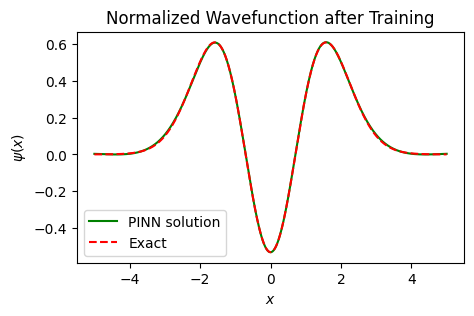

In [ ]:
# predicted solution at the end of training
indices = torch.linspace(0, len(x_test)-1, steps=10).long()
print("Predicted psi(x) values")
for i in range(10):
  print(f"x = {x_test.detach().numpy()[indices[i]].squeeze():.6f}, psi = {psi_plot[indices[i],-1].squeeze():.6f}")

# comparison of final PINN solution with exact solution
psi_pinn = psi_plot[:,-1]
psi_exact = loss_funcs.analytic(x_val.detach().numpy())

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.plot(x_val.detach().numpy(), psi_pinn, color='g', label="PINN solution")
plt.plot(x_val.detach().numpy(), psi_exact, color='r', linestyle='--', label="Exact")
plt.xlabel(r'$x$')
plt.ylabel(r'$\psi(x)$')
plt.title(r'Normalized Wavefunction after Training')
plt.legend()
plt.show()

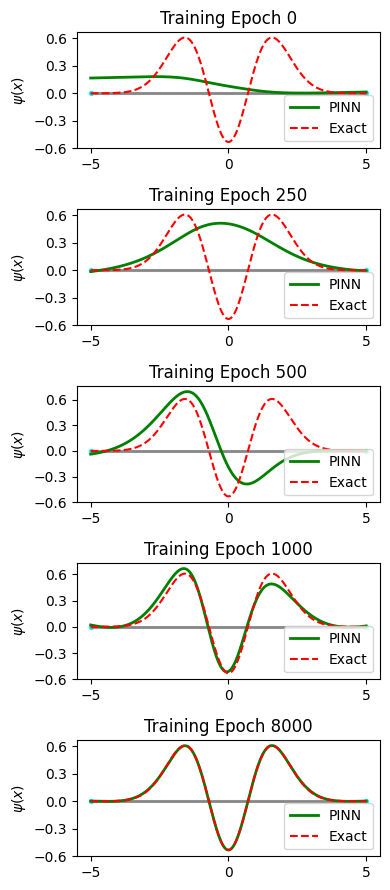

In [ ]:
# plot the PINNs solution over training
epoch_num = [0, 250, 500, 1000, 8000]
fig, ax = plt.subplots(len(epoch_num), 1, figsize=(4, 9))

for i in range(len(epoch_num)):
  ax[i].scatter(x_boundary.detach()[:,0], torch.zeros_like(x_boundary)[:,0], s=15, lw=0, color="cyan")
  ax[i].scatter(x_physics.detach()[:,0], torch.zeros_like(x_physics)[:,0], s=5, lw=0, color='grey', alpha=0.2)
  ax[i].plot(x_test[:,0], psi_plot[:,epoch_num[i]], lw=2, label="PINN", color='g')
  ax[i].plot(x_val.detach().numpy(), psi_exact, color='r', linestyle='--', lw=1.5, label="Exact")
  ax[i].set_title(f"Training Epoch {epoch_num[i]}", fontsize=12)
  ax[i].set_xticks([-5,0,5])
  ax[i].set_yticks([-0.6, -0.3, 0, 0.3, 0.6])
  ax[i].legend(fontsize=10, loc='lower right')
  ax[i].set_ylabel(r'$\psi(x)$', fontsize=10)

#ax[-1].set_xlabel(r'$x$', fontsize=12)
plt.tight_layout()
plt.savefig("n1_train.pdf")
plt.show()

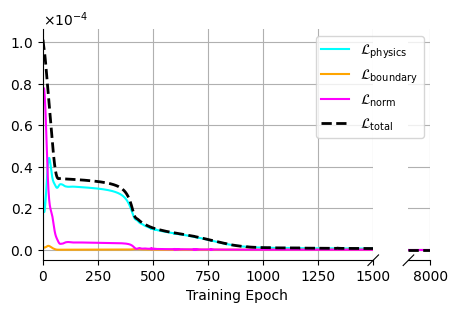

In [ ]:
# plot the loss curve
epoch = np.arange(num_epochs+1)

labels = [r"$\mathcal{L}_\text{physics}$", r"$\mathcal{L}_\text{boundary}$", r"$\mathcal{L}_\text{norm}$", r"$\mathcal{L}_\text{total}$"]
styles = ["-", "-", "-", "--"]
colors = ["cyan", "orange", "magenta", "black"]
linewidths = [1.5, 1.5, 1.5, 2]

fig = plt.figure(figsize=(5, 3))
bax = BrokenAxes(xlims=((0, 1500), (7900, 8000)))

for loss_type, label, color, style, linew in zip(
        [physics_loss, boundary_loss, norm_loss, total_loss],
        labels,
        colors,
        styles,
        linewidths):
    bax.plot(epoch, loss_type, linestyle=style, lw=linew, label=label, color=color, alpha=1)

for ax in bax.axs:
    ax.tick_params(axis='x', labelsize=10)
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

bax.set_xlabel("Training Epoch", labelpad=20)
bax.grid()
bax.legend()
plt.savefig("n1_loss.pdf", bbox_inches="tight")
plt.show()

For $n=2$:

In [ ]:
# define boundary points
x_boundary = torch.tensor([-5., 5.]).view(-1, 1).requires_grad_(True)

# define training points
x_physics = torch.linspace(-5, 5, 1000).view(-1, 1).requires_grad_(True)

# define test points (plotting)
x_test = torch.linspace(-5, 5, 1000).view(-1, 1)

# define validation points
x_val = torch.linspace(-5, 5, 1000).view(-1, 1)

# train PINN
hbar, m, omega = 1, 1, 1
lambda_b, lambda_p = 1e-4, 1e-4
num_epochs = 8000

# initialize PINN
PINN = FFNN(num_features=1, num_hidden=64, num_output=1)
optimizer = optim.Adam(PINN.parameters(), lr=1e-4)

# store solutions as training progresses
psi_plot = np.empty((x_test.shape[0], 0))

# setup lists to store training loss and validation error
boundary_loss = []
physics_loss = []
norm_loss = []
total_loss = []
train_error = []
val_error = []

for e in range(num_epochs+1):
  # zero accumulated gradients in parameters
  optimizer.zero_grad()

  # define loss functions
  loss_funcs = LossFunctions(hbar, m, omega, n=2, lambda_b=lambda_b, lambda_p=lambda_p, lambda_n=1e-4)

  # compute boundary loss
  psi = PINN(x_boundary)
  L_boundary = loss_funcs.boundary_loss(psi)
  boundary_loss.append(L_boundary.item())

  # compute physics loss
  psi = PINN(x_physics)
  dpsi_dt = autograd.grad(psi, x_physics, torch.ones_like(psi), create_graph=True)[0]
  d2psi_dt2 = autograd.grad(dpsi_dt, x_physics, torch.ones_like(dpsi_dt), create_graph=True)[0]
  L_physics = loss_funcs.physics_loss(x_physics, psi, d2psi_dt2)
  physics_loss.append(L_physics.item())

  # compute norm loss
  L_norm = loss_funcs.norm_loss(x_physics, psi)
  norm_loss.append(L_norm.item())

  # backpropagate joint loss
  L_total = L_boundary + L_physics + L_norm
  L_total.backward()
  total_loss.append(L_total.item())
  optimizer.step()

  # store training loss and validation error
  if e % 1000 == 0:
    # append training error
    train_error.append(L_total.item())

    # compute and append validation error
    psiv = PINN(x_val)
    val_error.append(torch.mean(torch.abs(psiv - loss_funcs.analytic(x_val))**2))
    print(f"Epoch: {e:4d}, Training Error: {train_error[-1]:.6e}, Validation Loss: {val_error[-1]:.6e}")

  # store solution (plotting)
  psi_e = PINN(x_test).detach().numpy()
  psi_plot = np.hstack((psi_plot, psi_e))

Epoch:    0, Training Error: 1.012613e-04, Validation Loss: 8.860943e-02
Epoch: 1000, Training Error: 1.015753e-06, Validation Loss: 2.400560e-03
Epoch: 2000, Training Error: 4.527369e-07, Validation Loss: 2.172598e-04
Epoch: 3000, Training Error: 2.934540e-07, Validation Loss: 1.090968e-04
Epoch: 4000, Training Error: 1.860835e-07, Validation Loss: 6.392439e-05
Epoch: 5000, Training Error: 1.150819e-07, Validation Loss: 3.630454e-05
Epoch: 6000, Training Error: 7.248767e-08, Validation Loss: 2.024218e-05
Epoch: 7000, Training Error: 4.804653e-08, Validation Loss: 1.181611e-05
Epoch: 8000, Training Error: 3.328385e-08, Validation Loss: 7.436860e-06


Predicted psi(x) values
x = -5.000000, psi = 0.002975
x = -3.888889, psi = 0.006322
x = -2.777778, psi = 0.167786
x = -1.666667, psi = 0.601169
x = -0.555556, psi = -0.173171
x = 0.555556, psi = -0.174586
x = 1.666667, psi = 0.603606
x = 2.777778, psi = 0.167244
x = 3.888889, psi = 0.006576
x = 5.000000, psi = 0.003218


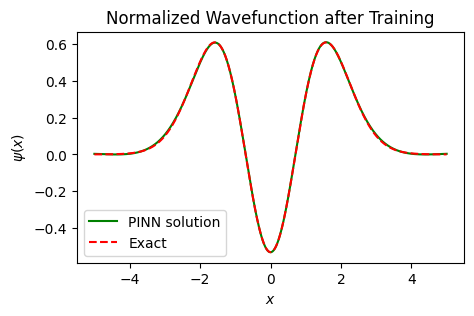

In [ ]:
# predicted solution at the end of training
indices = torch.linspace(0, len(x_test)-1, steps=10).long()
print("Predicted psi(x) values")
for i in range(10):
  print(f"x = {x_test.detach().numpy()[indices[i]].squeeze():.6f}, psi = {psi_plot[indices[i],-1].squeeze():.6f}")

# comparison of final PINN solution with exact solution
psi_pinn = psi_plot[:,-1]
psi_exact = loss_funcs.analytic(x_val.detach().numpy())

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.plot(x_val.detach().numpy(), psi_pinn, color='g', label="PINN solution")
plt.plot(x_val.detach().numpy(), psi_exact, color='r', linestyle='--', label="Exact")
plt.xlabel(r'$x$')
plt.ylabel(r'$\psi(x)$')
plt.title(r'Normalized Wavefunction after Training')
plt.legend()
plt.show()

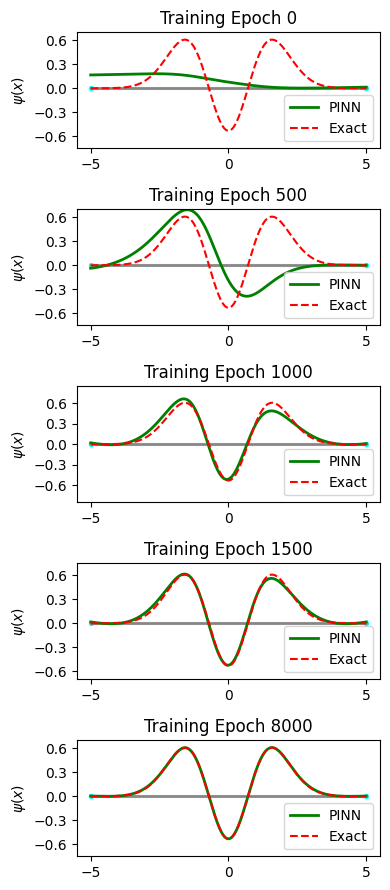

In [ ]:
# plot the PINNs solution over training
epoch_num = [0, 500, 1000, 1500, 8000]
fig, ax = plt.subplots(len(epoch_num), 1, figsize=(4, 9))

for i in range(len(epoch_num)):
  ax[i].scatter(x_boundary.detach()[:,0], torch.zeros_like(x_boundary)[:,0], s=15, lw=0, color="cyan")
  ax[i].scatter(x_physics.detach()[:,0], torch.zeros_like(x_physics)[:,0], s=5, lw=0, color='grey', alpha=0.2)
  ax[i].plot(x_test[:,0], psi_plot[:,epoch_num[i]], lw=2, label="PINN", color='g')
  ax[i].plot(x_val.detach().numpy(), psi_exact, color='r', linestyle='--', lw=1.5, label="Exact")
  ax[i].set_title(f"Training Epoch {epoch_num[i]}", fontsize=12)
  ax[i].set_xticks([-5,0,5])
  ax[i].set_yticks([-0.6, -0.3, 0, 0.3, 0.6])
  ax[i].legend(fontsize=10, loc='lower right')
  ax[i].set_ylabel(r'$\psi(x)$', fontsize=10)

#ax[-1].set_xlabel(r'$x$', fontsize=12)
ax[0].set_ylim([-0.75, 0.7])
ax[1].set_ylim([-0.75, 0.7])
ax[2].set_ylim([-0.85, 0.85])
ax[3].set_ylim([-0.7, 0.75])
ax[4].set_ylim([-0.75, 0.7])
plt.tight_layout()
plt.savefig("n2_train.pdf")
plt.show()

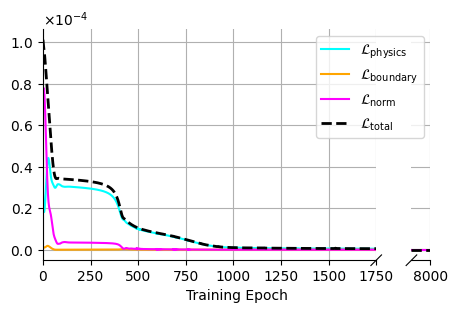

In [ ]:
# plot the loss curve
epoch = np.arange(num_epochs+1)

labels = [r"$\mathcal{L}_\text{physics}$", r"$\mathcal{L}_\text{boundary}$", r"$\mathcal{L}_\text{norm}$", r"$\mathcal{L}_\text{total}$"]
styles = ["-", "-", "-", "--"]
colors = ["cyan", "orange", "magenta", "black"]
linewidths = [1.5, 1.5, 1.5, 2]

fig = plt.figure(figsize=(5, 3))
bax = BrokenAxes(xlims=((0, 1750), (7900, 8000)))

for loss_type, label, color, style, linew in zip(
        [physics_loss, boundary_loss, norm_loss, total_loss],
        labels,
        colors,
        styles,
        linewidths):
    bax.plot(epoch, loss_type, linestyle=style, lw=linew, label=label, color=color, alpha=1)

for ax in bax.axs:
    ax.tick_params(axis='x', labelsize=10)
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

bax.set_xlabel("Training Epoch", labelpad=20)
bax.grid()
bax.legend()
plt.savefig("n2_loss.pdf", bbox_inches="tight")
plt.show()